In [9]:
from alns import ALNS, State
from alns.criteria import HillClimbing

import itertools

import numpy.random as rnd

import pandas as pd 

import networkx as nx

import tsplib95
import tsplib95.distances as distances

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
SEED = 9876

In [4]:
data = tsplib95.load_problem('xqf131.tsp')

solution = tsplib95.load_solution('xqf131.opt.tour')
optimal = data.trace_tours(solution)[0]

print('Total optimal tour length is {0}.'.format(optimal))

Total optimal tour length is 564.


In [56]:
def draw_graph(graph, only_nodes=False):
    """
    Helper method for drawing TSP (tour) graphs.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    func = nx.draw_networkx

    if only_nodes:
        func = nx.draw_networkx_nodes

    func(graph, data.node_coords, node_size=25, with_labels=False, ax=ax)

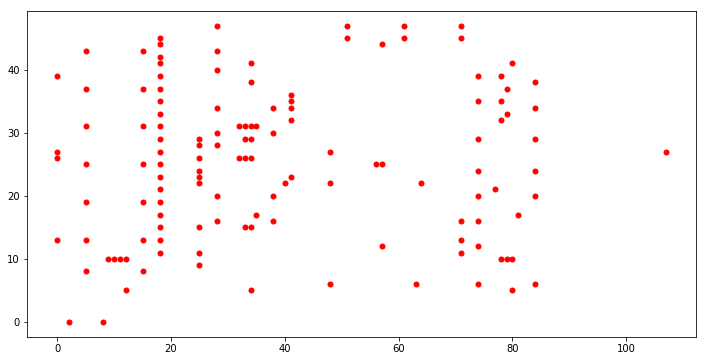

In [57]:
draw_graph(data.get_graph(), True)

In [72]:
class TopKState(State):
    """
    Solution class for the top k worker task assignmnet problem 
    """

    def __init__(self, tasks, workers):
        self.tasks = tasks
        self.workers = workers
        

    def copy(self):
        """
        Helper method to ensure each solution state is immutable.
        """
        return TspState(self.tasks.copy(),
                        self.workers.copy())

    def objective(self):
        """
        The objective function is simply the sum of all Assignment qualities
        """
        return sum(self.Assignmnet.loc[worker,task])


In [73]:

degree_of_destruction = 0.25

def workers_to_remove(state):
    return int(len(state.workers) * degree_of_destruction)

In [60]:
def worst_removal(current, random_state):
    """
    Worst removal iteratively removes the 'worst' workers, that is,
    those workers that have the lowest quality.
    """
    destroyed = current.copy()

    worst_workers = sorted(destroyed.tasks,
                         key=lambda task: distances.euclidean(node[1],
                                                              destroyed.workers[task][1]))

    for idx in range(workers_to_remove(current)):
        del destroyed.workers[worst_workers[-idx -1]]
    
    return destroyed

In [61]:
def path_removal(current, random_state):
    """
    Removes an entire consecutive subpath, that is, a series of
    contiguous edges.
    """
    destroyed = current.copy()
    
    node_idx = random_state.choice(len(destroyed.nodes))
    node = destroyed.nodes[node_idx]
    
    for _ in range(edges_to_remove(current)):
        node = destroyed.edges.pop(node)
  
    return destroyed

In [62]:
def random_removal(current, random_state):
    """
    Random removal iteratively removes random edges.
    """
    destroyed = current.copy()
    
    for idx in random_state.choice(len(destroyed.nodes),
                                   edges_to_remove(current),
                                   replace=False):
        del destroyed.edges[destroyed.nodes[idx]]
  
    return destroyed

In [63]:
def would_form_subcycle(from_node, to_node, state):
    """
    Ensures the proposed solution would not result in a cycle smaller
    than the entire set of nodes. Notice the offsets: we do not count
    the current node under consideration, as it cannot yet be part of
    a cycle.
    """
    for step in range(1, len(state.nodes)):
        if to_node not in state.edges:
            return False

        to_node = state.edges[to_node]
        
        if from_node == to_node and step != len(state.nodes) - 1:
            return True
   
    return False

In [64]:
def greedy_repair(current, random_state):
    """
    Greedily repairs a tour, stitching up nodes that are not departed
    with those not visited.
    """
    visited = set(current.edges.values())
  
    # This kind of randomness ensures we do not cycle between the same
    # destroy and repair steps every time.
    shuffled_idcs = random_state.permutation(len(current.nodes))
    nodes = [current.nodes[idx] for idx in shuffled_idcs]

    while len(current.edges) != len(current.nodes):
        node = next(node for node in nodes 
                    if node not in current.edges)

        # Computes all nodes that have not currently been visited,
        # that is, those that this node might visit. This should
        # not result in a subcycle, as that would violate the TSP
        # constraints.
        unvisited = {other for other in current.nodes
                     if other != node
                     if other not in visited
                     if not would_form_subcycle(node, other, current)}

        # Closest visitable node.
        nearest = min(unvisited,
                      key=lambda other: distances.euclidean(node[1], other[1]))

        current.edges[node] = nearest
        visited.add(nearest)
   
    return current

In [74]:
random_state = rnd.RandomState(SEED) #generating random numbers drawn from a variety of probability distributions

state = TspState(list(data.node_coords.items()), {})
print(state)
initial_solution = greedy_repair(state, random_state)

print("Initial solution objective is {0}.".format(initial_solution.objective()))

I'M __init__
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
Initial solution objective is 842.


I'M to_graph


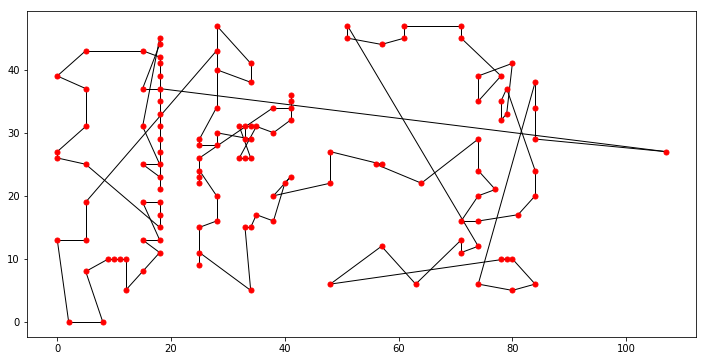

In [66]:
draw_graph(initial_solution.to_graph())

In [67]:
alns = ALNS(random_state)

alns.add_destroy_operator(random_removal)
alns.add_destroy_operator(path_removal)
alns.add_destroy_operator(worst_removal)

alns.add_repair_operator(greedy_repair)

In [70]:
# This is perhaps the simplest selection criterion, where we only accept
# progressively better solutions.
criterion = HillClimbing()

result = alns.iterate(initial_solution, [3, 2, 1, 0.5], 0.8, criterion,
                      iterations=5000, collect_stats=True)

solution = result.best_state

objective = solution.objective()
print("obkective ---------------------", objective)

I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE


I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE


I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'

I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I

I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'

I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M 

I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M g

I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M

I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I

I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_su

I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M

I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJE

I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'

I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECT

I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M 

I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECT

I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M 

I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M

I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'

I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair

I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M

I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M

I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE


I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair


I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'

I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M 

I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE

I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'

I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE

I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair

I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M 

I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M

I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE


I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M O

I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I

I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair


I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'

I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M

I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M

I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M

I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_remov

I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M 

I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE

I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M

I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M

I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'

I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M O

I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__


I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTI

I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'

I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal

I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M O

I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECT

I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form

I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M 

I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTI

I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'

I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I

I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE

I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M

I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'

I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__


I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M 

I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M O

I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I

I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I

I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTI

I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_for

I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE


I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form

I'M __init__
I'M PATH_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M RANDOM_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M  COPY
I'M __init__
I'M worst_removal
I'M would_form_subcycle
I'M greey repair
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIVE
I'M OPJECTIV

Best heuristic objective is 600.
This is 6.4% worse than the optimal solution, which is 564.


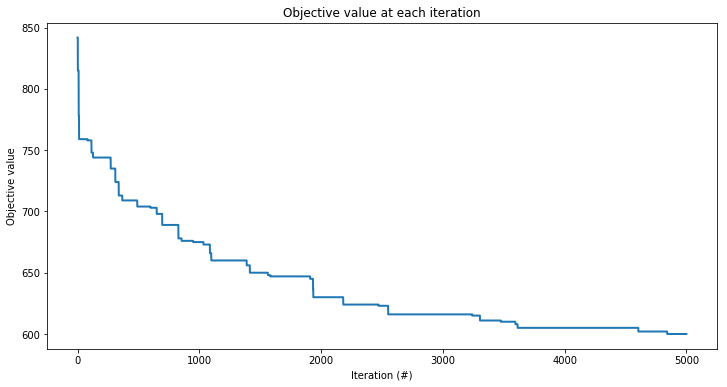

In [69]:
print('Best heuristic objective is {0}.'.format(objective))
print('This is {0:.1f}% worse than the optimal solution, which is {1}.'
      .format(100 * (objective - optimal) / optimal, optimal))

_, ax = plt.subplots(figsize=(12, 6))
result.plot_objectives(ax=ax, lw=2)

Area of Rectangle: 19200 sq units
